In [1]:
dataset <- "SIRToscana"
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Toscana"
match_dist <- 15000
new_dataset <- "TOS"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
Sys.setlocale("LC_ALL", "UTF-8")
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/database/query/metadata.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


[1] "C/UTF-8/C/C/C/C"

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = 10000) |>
    st_drop_geometry() |>
    filter(!state %in% c("Liguria", "Emilia-Romagna", "Umbria", "Lazio", "Marche"))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    filter(!(dataset == "SCIA" & sensor_key %in% c(1401L, 1758L, 2724L, 2728L, 4225L))) # Firenze, Isola d'Elba, Passo Porretta, Volterra

metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

misplaced <- similar_namesdist(metadata_db, conns$stations, threshold = 0.685) |>
    left_join(metadata |> select(key, name, dataset), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, dataset), by = c("key_y" = "key")) |>
    filter(distance >= match_dist, key_x < key_y, strSym > 0.965 | (strSym >= 0.9 & name.x |>
        str_to_lower() |>
        str_detect(regex("(greve)|(orbetello)"))) | if_all(starts_with("name."), ~ . |>
        str_to_lower() |>
        str_detect("monterotondo"))) |>
    select(key_x, key_y, distance)
sensor_matches <- close_matches(metadata_db, match_dist, conns$stations) |>
    bind_rows(misplaced)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "ds_regionali", state, "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"), starts_with("tag_"))


In [6]:
path_from <- prepare_data_for_merge(conns$data)
saved_to <- merge_same_series(path_from, fs::path("db", "tmp"), new_dataset, tagged_analysis, metadata, data, 1, 2L*365L, merging_datasets, desc(dataset), desc(sensor_last), desc(network))
merged_checkpoint(new_dataset, saved_to, metadata)

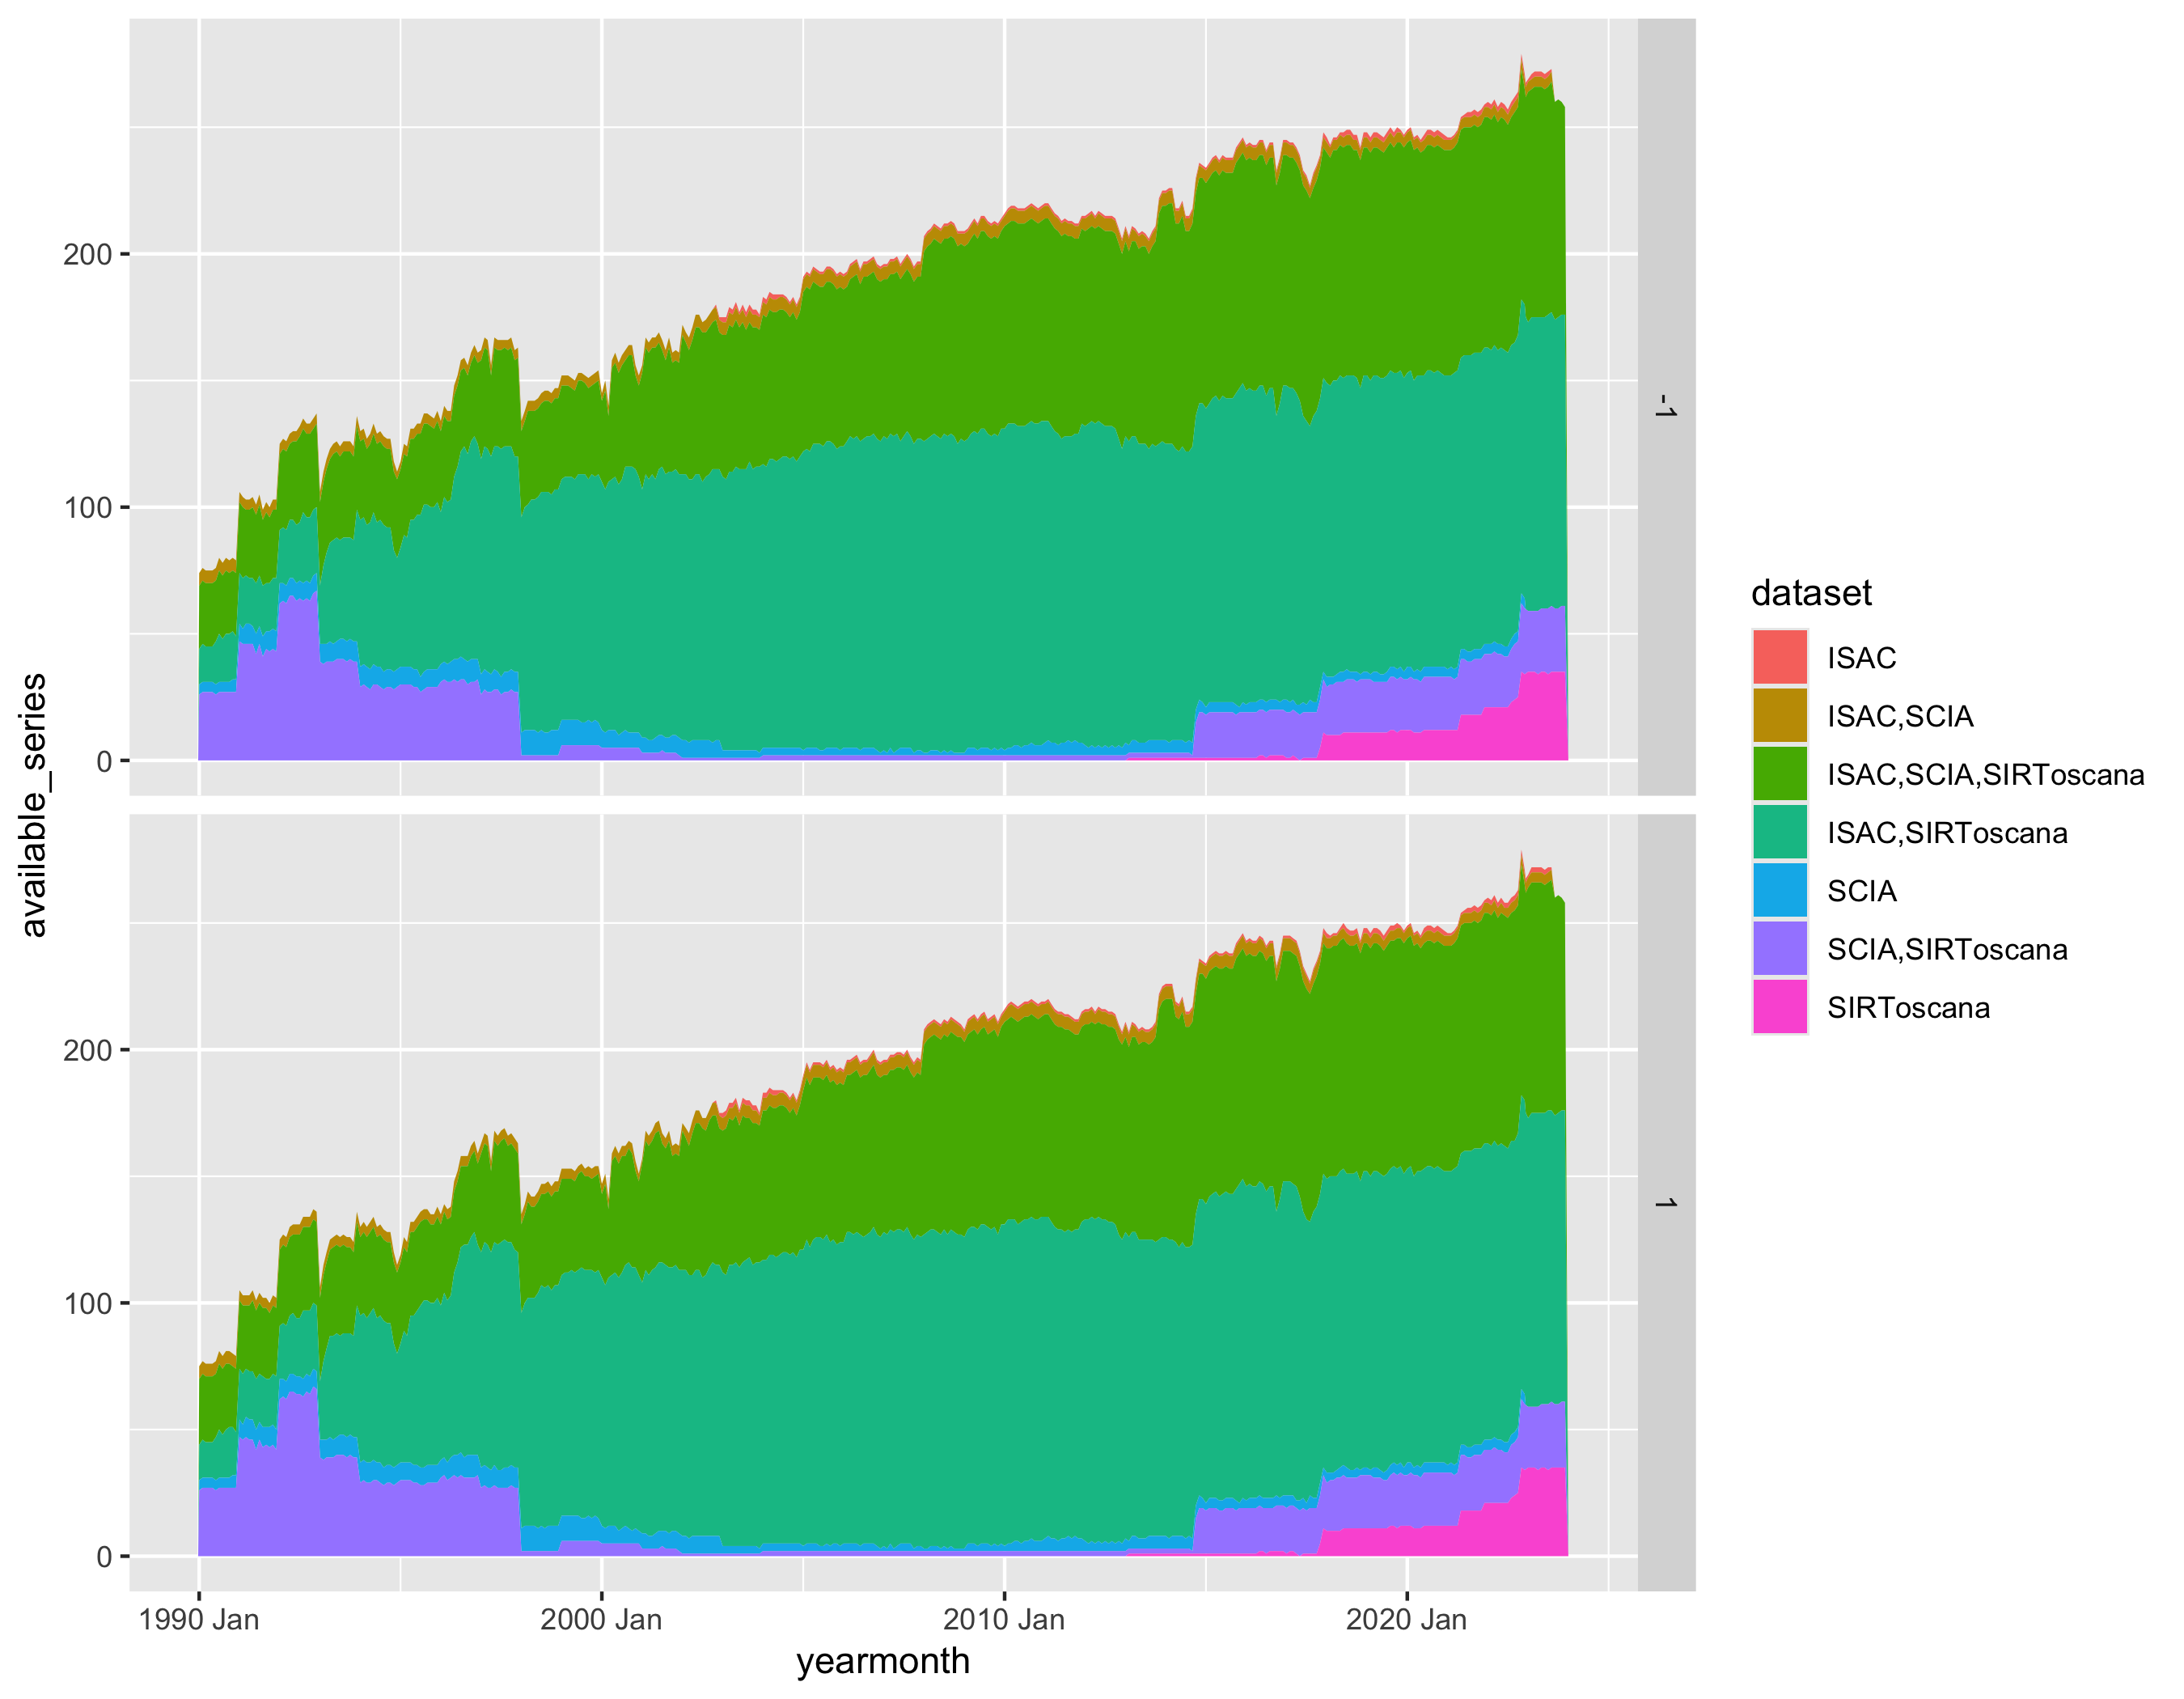

In [7]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


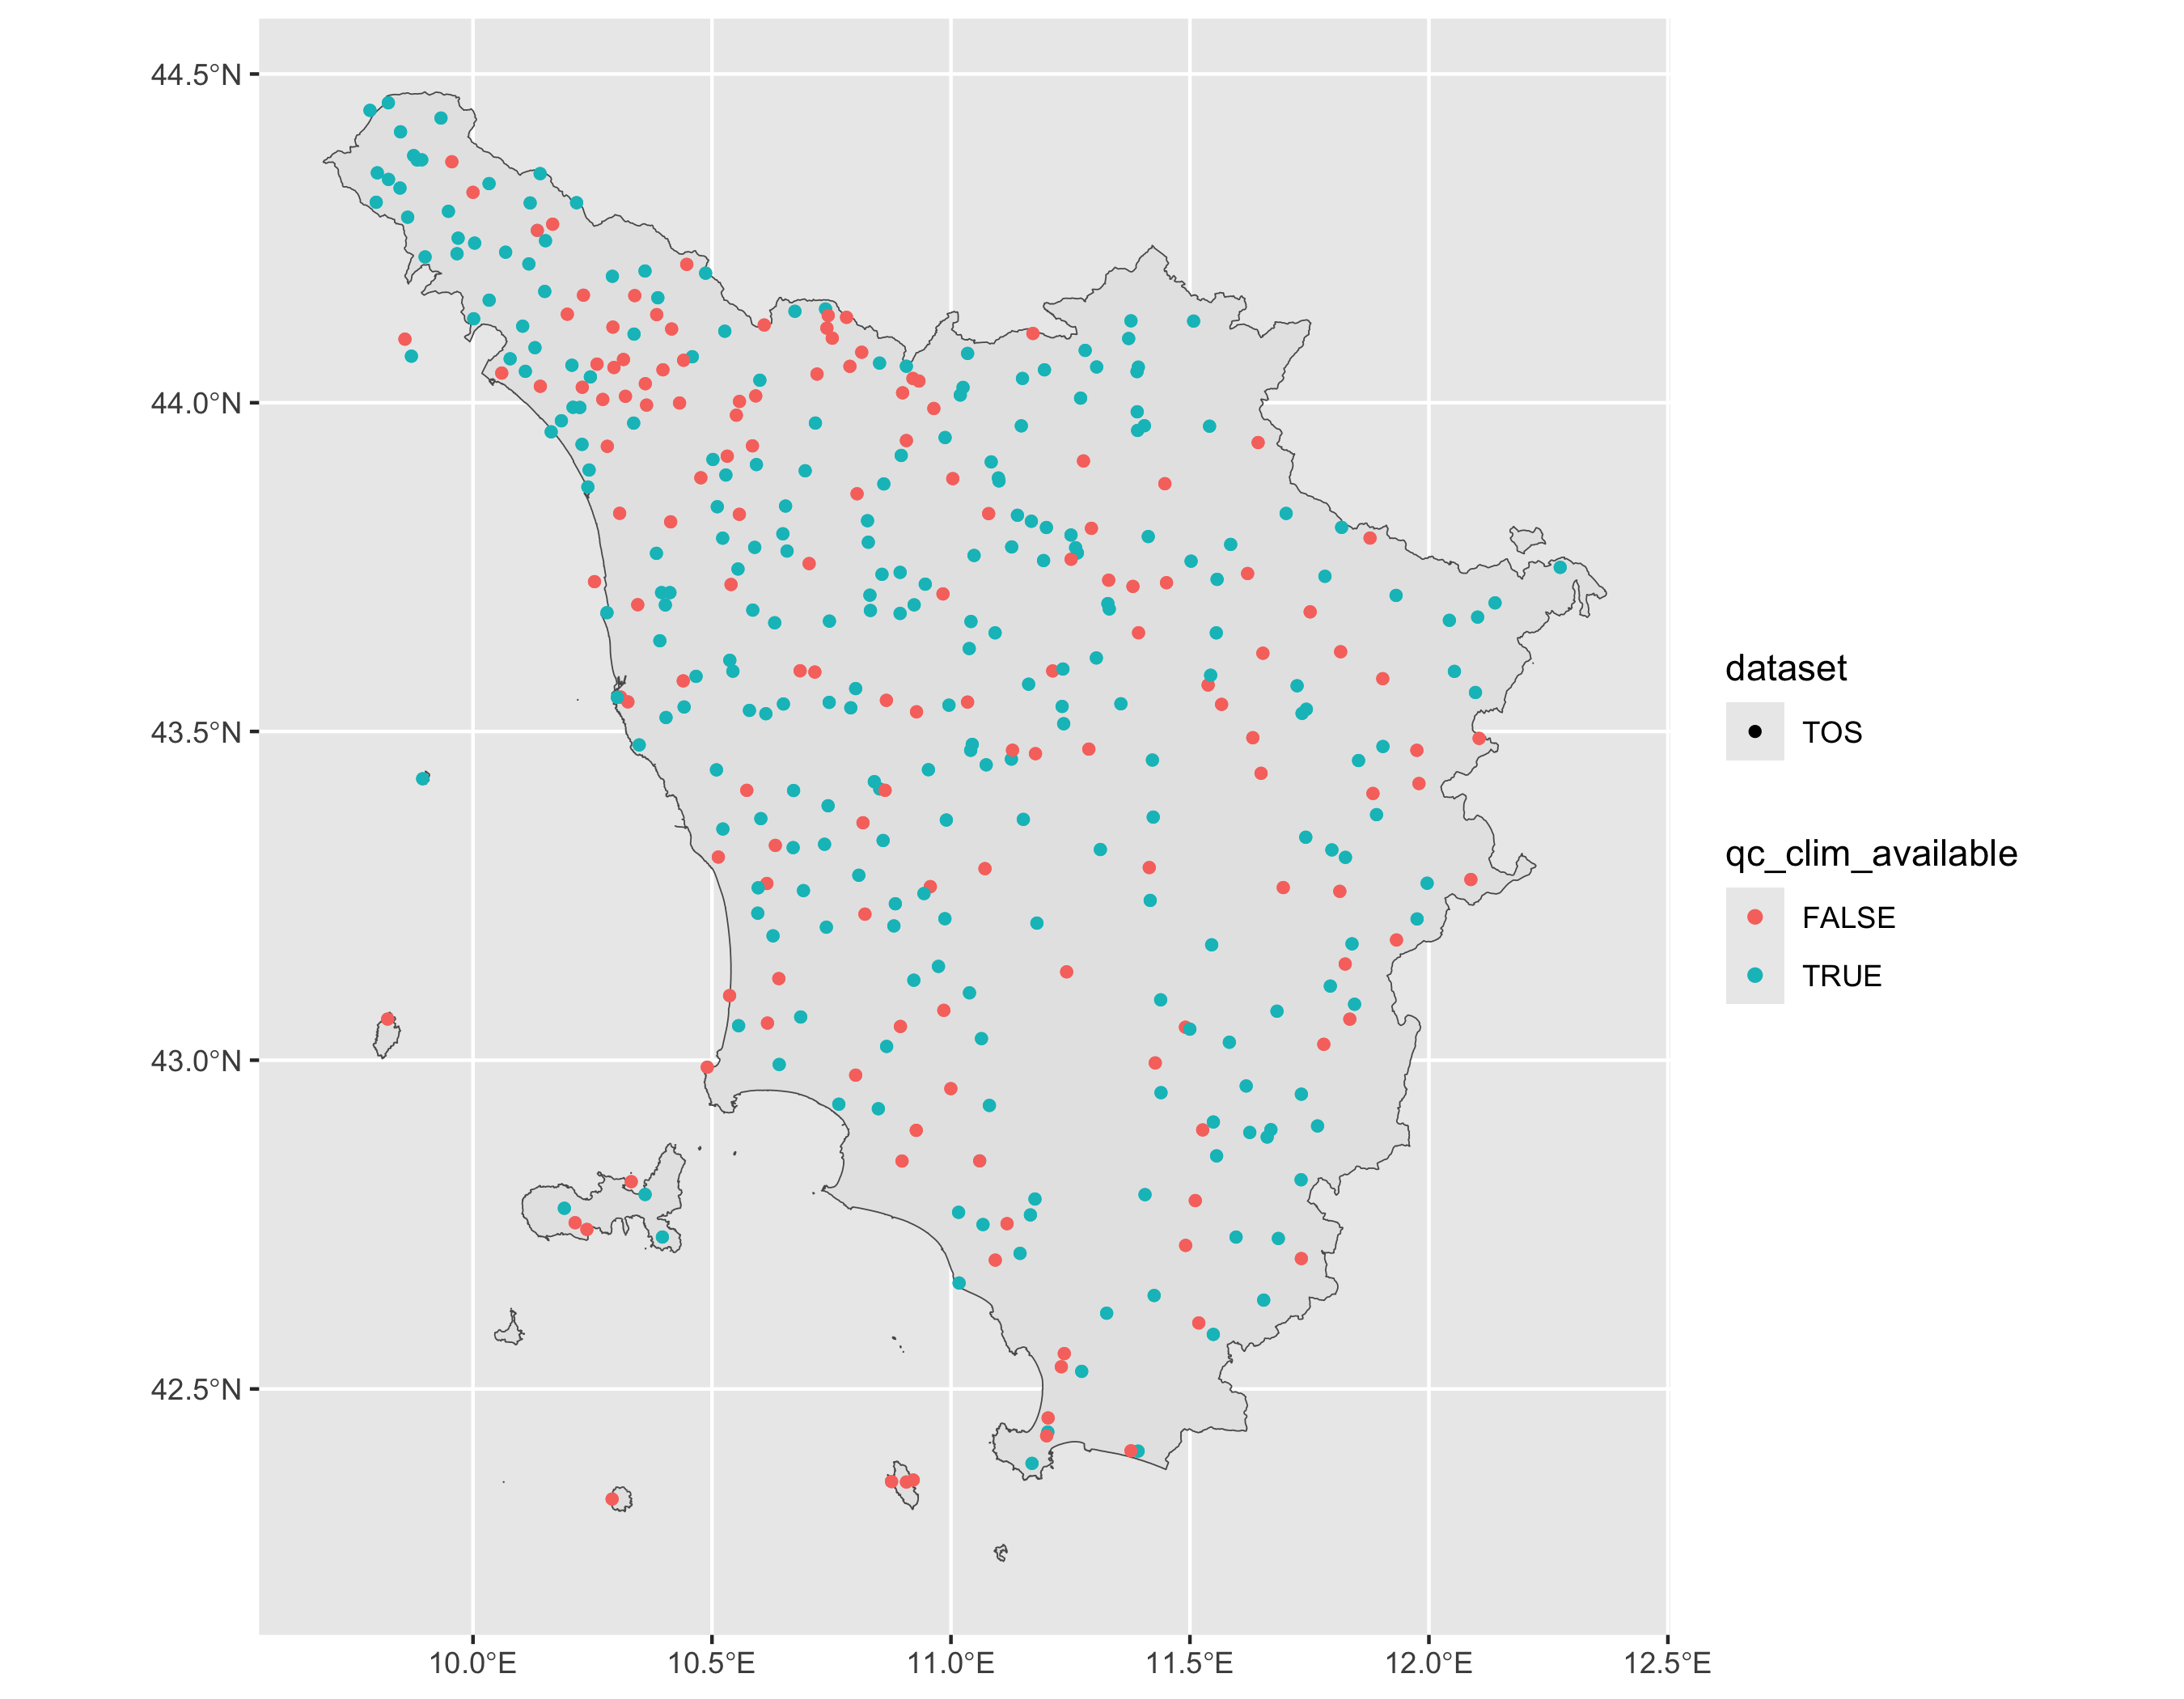

In [8]:
sp_data <- pd[[2]] |> mutate(dataset = new_dataset)
pd <- spatial_availabilities(sp_data, db$meta, state_boundaries)
pd$plot


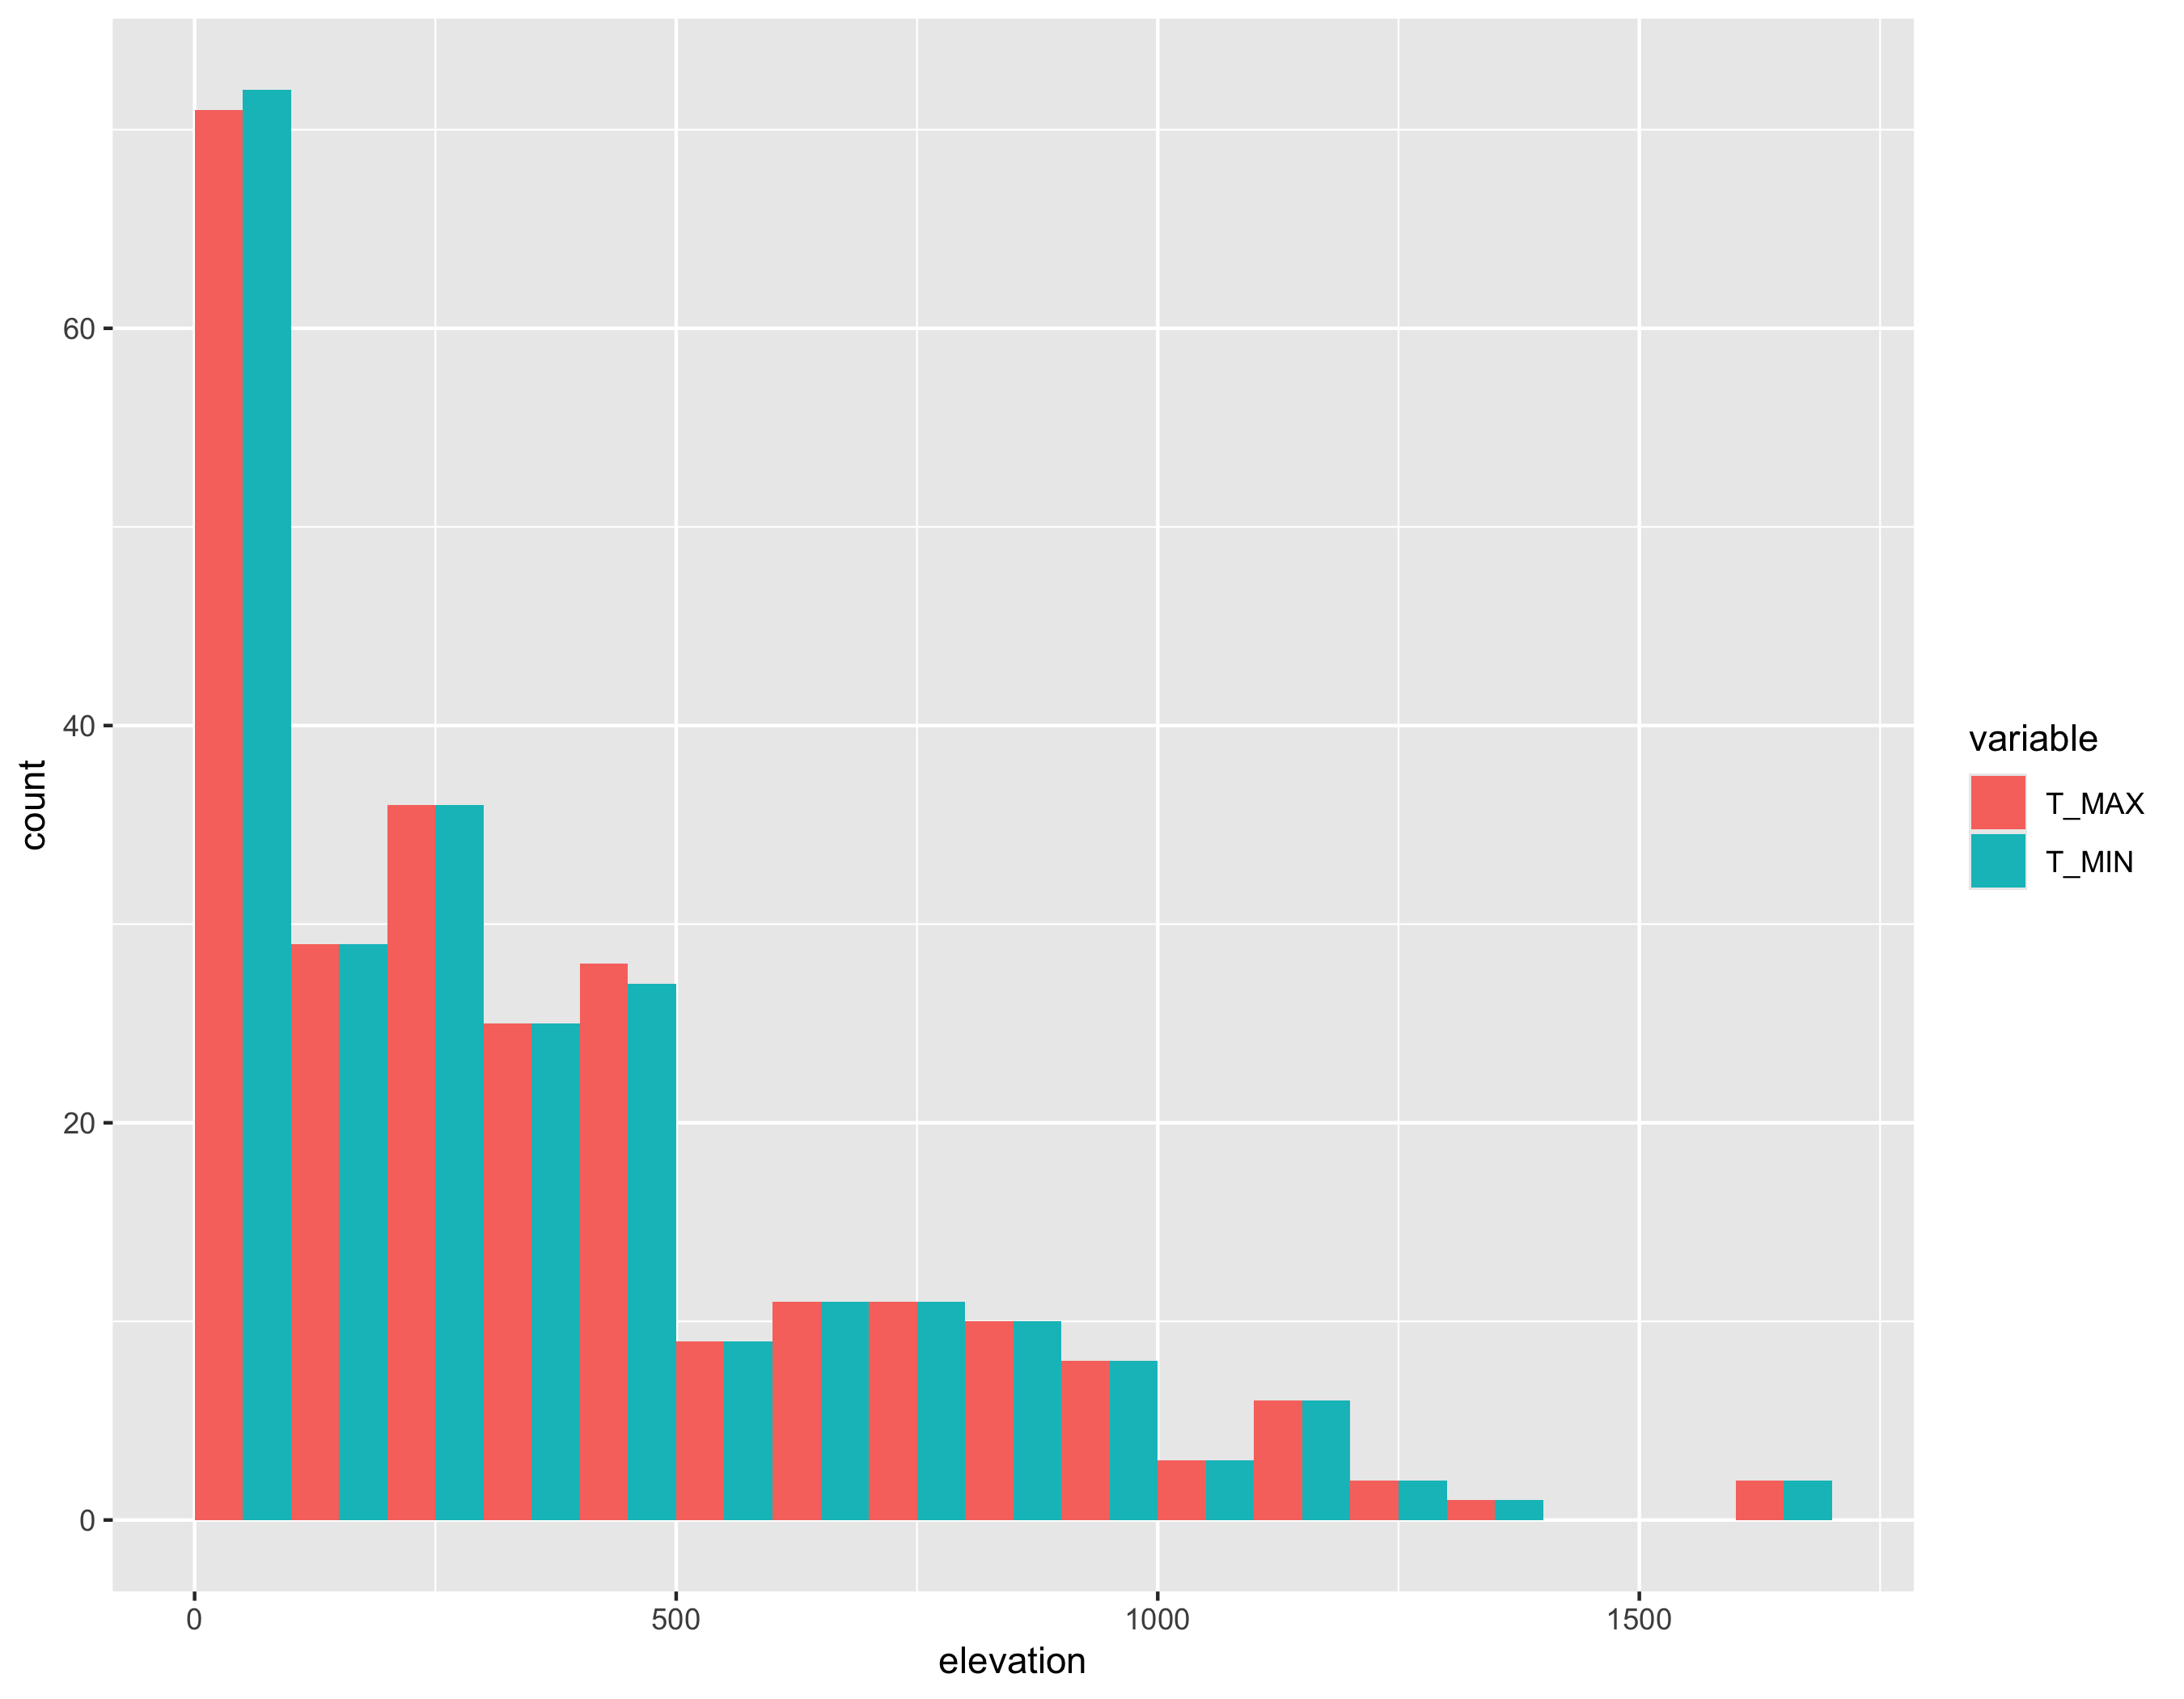

In [9]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())


In [10]:
merge_specs <- read_parquet(str_glue("db/extra/merge_specs/{new_dataset}.parquet")) |>
    mutate(km = k0 + 2 * k1 / pi)
merge_specs |>
    filter(abs(km) > 0.5) |>
    arrange(desc(abs(km))) |>
    left_join(metadata |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key")) |>
    relocate(km, name)

km,name,set,gkey,variable,metadata_rank,data_rank,skip_correction,dataset,sensor_key,force_merge,k0,k1,k2,k3,merged,offset
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<chr>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>
1.0650604,Carrara,TOS,43,1,2,2,FALSE,SIRToscana,69,FALSE,0.7332795,0.5211602,0.076531792,-0.01270720,FALSE,0
1.0649659,Carrara,TOS,43,1,3,3,FALSE,SCIA,972,FALSE,0.7327729,0.5218076,0.076519564,-0.01271337,FALSE,0
-0.9825093,Suvereto,TOS,227,-1,3,3,FALSE,SCIA,3900,FALSE,-0.4473219,-0.8406704,-0.009353191,-0.08667417,FALSE,0
-0.9821494,Suvereto,TOS,227,-1,2,2,FALSE,SIRToscana,401,FALSE,-0.4474883,-0.8398436,-0.009010435,-0.08684639,TRUE,0
-0.8498142,Monte Serra,TOS,145,1,4,4,FALSE,SCIA,2418,FALSE,0.3168518,-1.8325946,-0.056637699,-0.07361051,FALSE,-1
-0.8479920,Monte Serra,TOS,145,1,2,2,FALSE,SIRToscana,219,FALSE,0.3233412,-1.8399259,-0.056672318,-0.07360597,FALSE,-1
-0.6659788,MONTE_SERRA_CAE,TOS,145,1,7,7,FALSE,ISAC,2245,FALSE,0.5358621,-1.8878472,-0.045439456,-0.07444147,FALSE,0
